In [1]:
import numpy as np 
import celerite
from celerite import terms
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astroML.plotting.mcmc import convert_to_stdev
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## Plot the log-likelihood space for Celerite ... 

In [2]:
def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag

def sampling(tau_in = 100, length=10, t_min=1, dt = 10 , 
                        regular=False, verbose=False):
    ''' A convenience function to return user-defined sampling 
    
    Input: 
    -------
    tau_in : input timescale (default: 100 days )
    length : length in terms of multiples of timescale (default: 10) 
    t_min : starting point of lightcurve (default : 1 )
    dt : interval between samplings, if regular = True, then 
        this is the exact interval,  otherwise we divide the 
        light curve length by dt to determine the number 
        of points 
    regular : boolean (True / False). Use regular sampling with dt, 
        or random sampling with Npts = floor(total_timespan / dt) ? 
        
    Returns:
    ---------
    t : sampling times 
    '''
    t_max = t_min + length*tau_in
    if regular : 
        # evenly spaced sampling within the chosen interval 
        if verbose: 
            print('Using regular sampling')
        t = np.arange(t_min, t_max, dt)
    else :
        # random sampling with the chosen number of points ... 
        # The input coordinates must be sorted
        if verbose: 
            print('Using random sampling')
        Npts= int(np.floor((t_max - t_min) / dt))
        t = np.sort(np.random.uniform(t_min, t_max, Npts)) 
        
    return t


In [24]:
# Make a todays dir to save the figure ...
import os 
import datetime

outDir = os.path.join(os.getcwd()[:-len('code')],'data_products/Fig_Celerite_simulated_LC',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_simulated_LC/2017-06-22/


[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]


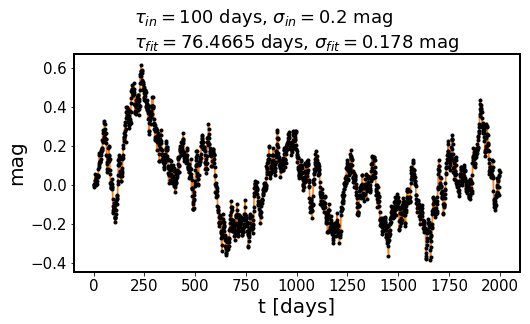

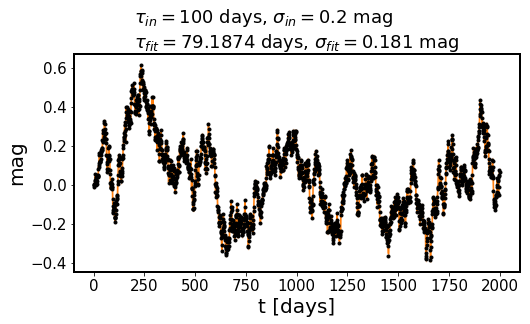

In [31]:
%matplotlib inline

# Simulate a DRW lightcurve and fit with celerite 
tau_in = 100
sigma_in = 0.2
SF_inf = sigma_in * np.sqrt(2)
yerr =  0.001 
#  length = 20 tau,  delta_time = 1 day 
t = sampling(tau_in = tau_in, length=20, regular=True, dt=1)
# we add the Gaussian noise with st.dev = yerr 
noise = np.random.normal(loc=0.0, scale=yerr, size=len(t))
y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0) + noise 
    
# fitting procedure : 

# initialize the kernel ... 
log_a_in = 2 * np.log(sigma_in)
log_c_in = np.log(1/tau_in)
kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)

# call the model 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

# optimization of the results 

sigma_bounds = [0.01, 1.0]
tau_bounds = [1,10000]
logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
bounds = [loga_bounds, logc_bounds]
#bounds = gp.get_parameter_bounds()
print(bounds)

initial_params = gp.get_parameter_vector()

for prior in ['jeffreys', 'flat'] : 
    if prior is 'jeffreys' :
        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
            return -gp.log_likelihood(y)- log_c  - log_a / 2 
        
    if prior is 'flat' : 
        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)

    r = minimize(neg_log_like, initial_params, 
                 method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)

    res = gp.get_parameter_dict()
    sigma_fit = np.exp(res['kernel:log_a']/2)
    tau_fit = 1.0 / np.exp(res['kernel:log_c'])

    # plot the prediction
    x = np.linspace(min(t),max(t) , 5000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    ax.plot(x, pred_mean, color=color)
    ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                     edgecolor="none")
    ax.set_xlabel('t [days]')
    ax.set_ylabel('mag')

    title = r'$\tau_{in}=$'+str(tau_in)+' days, ' +\
    r'$\sigma_{in}=$'+str(sigma_in)+' mag'+'\n'\
           +r'$\tau_{fit}=$'+str(tau_fit)[:7]+' days, '+\
        r'$\sigma_{fit}=$'+str(sigma_fit)[:5]+' mag'

    ax.set_title(title,multialignment='left')
    plt.savefig(outDir+'sim_lc_'+prior+'_prior_fit.png', bbox_inches='tight')

sim_lc = {'y':y, 't':t}
np.save( outDir+'sim_lc_y_t', sim_lc)

In [21]:
outDir

NameError: name 'outDir' is not defined

In [87]:
#Use exactly that light curve as above to make the figuere ... 
sim_lc = np.load(outDir + 'sim_lc_y_t.npy').item()
y = sim_lc['y']
t = sim_lc['t']

# initialize the kernel ... 
log_a_in = 2 * np.log(sigma_in)
log_c_in = np.log(1/tau_in)
kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)

# call the model 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

# Evaluate the log-likelihood manually on a grid of two parameters...
N = 200
# span the grid : truth is tau=100, sigma=0.2
tau_grid = np.linspace(10,300,N)
sigma_grid = np.linspace(0.1, 0.4, N)
# re-express in as logs since that's what go is fitting 
log_a_grid = 2 * np.log(sigma_grid)
log_c_grid = np.log(1/tau_grid)

# initialize as empty array
loglike = np.zeros([N,N], dtype=float)

for i in range(len(log_a_grid)):
    for j in range(len(log_c_grid)):
        params = [log_a_grid[i],log_c_grid[j]]
        gp.set_parameter_vector(params)
        loglike[i,j] = -gp.log_likelihood(y) # this is flat prior 



(array([ 30937.,   4963.,   1840.,    836.,    547.,    368.,    238.,
           154.,     84.,     33.]),
 array([-4263.38871226, -3373.08164622, -2482.77458019, -1592.46751416,
         -702.16044812,   188.14661791,  1078.45368394,  1968.76074998,
         2859.06781601,  3749.37488204,  4639.68194807]),
 <a list of 10 Patch objects>)

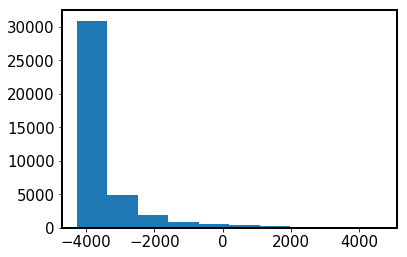

In [88]:
plt.hist(loglike.flatten())

In [89]:
# For the entire grid,  make alternative maps of NxN  (z-dimension),
# reflecting tau, sigma,  sigma_hat, 
# so that each point on the grid has a value 
# of sigma, tau, sigma_hat,  as well as logL 
z_loglike = loglike
z_tau = np.zeros([N,N] , dtype=float)
z_sigma = np.zeros([N,N], dtype=float)
z_sigma_hat = np.zeros([N,N], dtype=float)
z_K = np.zeros([N,N], dtype=float)
for i in range(len(sigma_grid)):
    for j in range(len(tau_grid)):
        z_tau[i,j] = tau_grid[j]
        z_sigma[i,j] = sigma_grid[i]
        z_sigma_hat[i,j] = sigma_grid[i] * np.sqrt(2 / tau_grid[j])
        z_K[i,j] = tau_grid[j] * np.sqrt(sigma_grid[i]) * np.power(2, 0.25)

(array([ 15125.,  15405.,   5261.,   2098.,   1003.,    535.,    292.,
           164.,     82.,     35.]),
 array([ 0.00816497,  0.02523701,  0.04230906,  0.05938111,  0.07645315,
         0.0935252 ,  0.11059725,  0.1276693 ,  0.14474134,  0.16181339,
         0.17888544]),
 <a list of 10 Patch objects>)

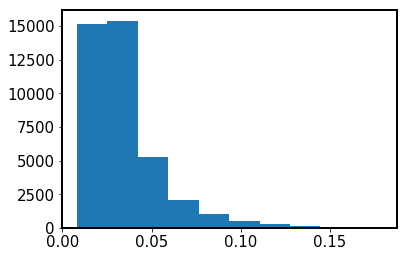

In [76]:
plt.hist(z_sigma_hat.flatten())

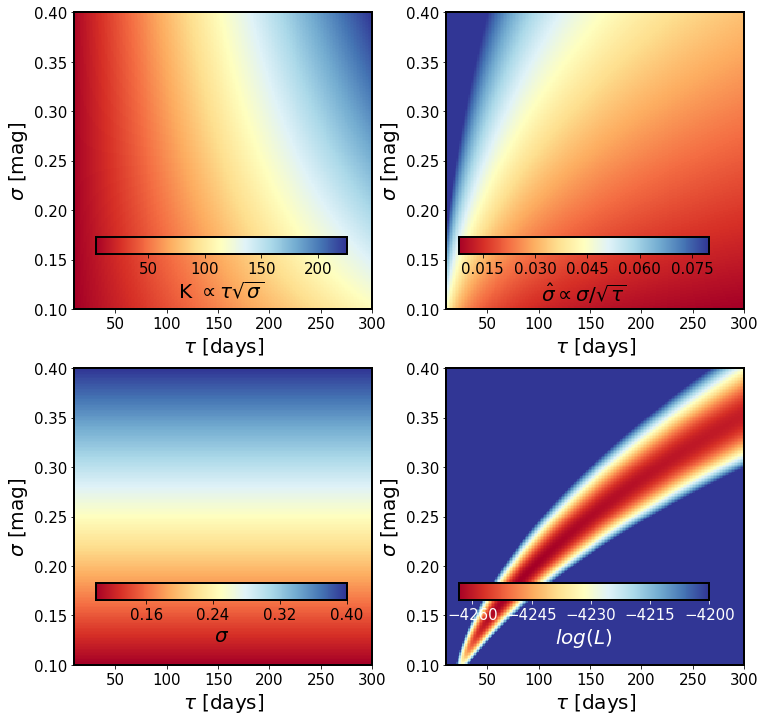

In [78]:
# Plot to show that it worked  : 
# Proof of concept 

fig,ax = plt.subplots(2,2,figsize=(12,12)) #, sharex=True, sharey=True
         


z = z_K
im = ax[0,0].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'),
               aspect='auto', origin='lower')
cax = fig.add_axes([0.15,0.6,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal', label='K '+r'$\propto \tau \sqrt{\sigma}$')
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$ [days]')
        ax[i,j].set_ylabel(r'$\sigma$ [mag]')
        
z = z_sigma_hat
im = ax[0,1].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'), vmax=0.08,
               aspect='auto', origin='lower')
cax = fig.add_axes([0.57,0.6,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal', label=r'$\hat{\sigma} \propto \sigma / \sqrt{\tau}$')
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()



z = z_sigma
im = ax[1,0].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'),
               aspect='auto', origin='lower')
cax = fig.add_axes([0.15,0.2,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal', label=r'$\sigma$')
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()



z = z_loglike
im = ax[1,1].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'), vmax=-4200,
               aspect='auto', origin='lower')
cax = fig.add_axes([0.57,0.2,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal')
cbar.set_label(label=r'$log(L)$', color='white')

from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.tick_params(colors='white')

fig.subplots_adjust(wspace=0.25)
# makes sense
plt.savefig(outDir+'sim_lc_logL_four_panels.png', bbox_inches='tight')

This makes sense, because we would expect that K is the combination of tau, sigma, just like sigma_hat,  and log-likelihood looks just fine as well.... 

In [69]:
cbar.set_label

(array([ 30937.,   4963.,   1840.,    836.,    547.,    368.,    238.,
           154.,     84.,     33.]),
 array([-1.06584718, -0.84327041, -0.62069365, -0.39811688, -0.17554011,
         0.04703665,  0.26961342,  0.49219019,  0.71476695,  0.93734372,
         1.15992049]),
 <a list of 10 Patch objects>)

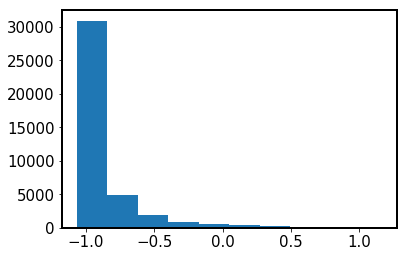

In [57]:
z = loglike / 4000
plt.hist(z.flatten())

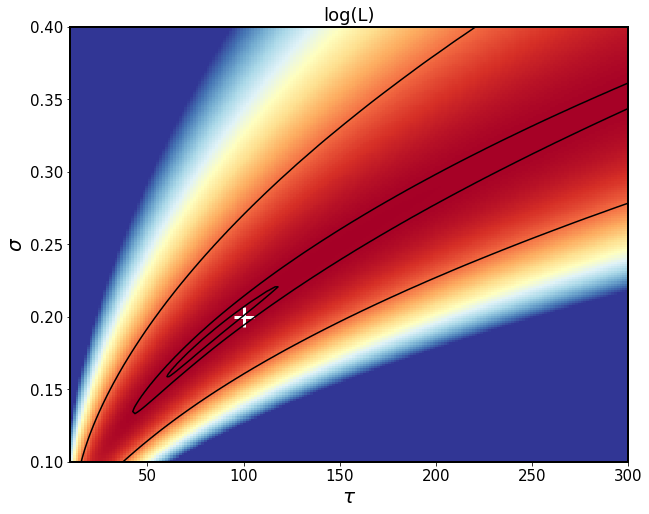

In [61]:
# Plot the loglikelihood and the contours...
# Using imshow 

fig,ax = plt.subplots(figsize=(10,8)) 

z = loglike /4000  # need to scale , otherwise we get too small numbers ... 

im = ax.imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'), vmax = -0.9,
               aspect='auto', origin='lower')

ax.contour(tau_grid, sigma_grid, convert_to_stdev(z),levels=(0.683, 0.955, 0.997), colors='k')
ax.scatter(tau_in, sigma_in, marker='+', s=400, lw=3, c='white')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\sigma$')
ax.set_title('log(L)')
plt.savefig(outDir + 'sim_lc_loglike.png', bbox_inches = 'tight')

In [50]:
sigma = np.exp(-loglike)
shape = sigma.shape
sigma = sigma.ravel()

# obtain the indices to sort and unsort the flattened array
i_sort = np.argsort(sigma)[::-1]
i_unsort = np.argsort(i_sort)

sigma_cumsum = sigma[i_sort].cumsum()
sigma_cumsum /= sigma_cumsum[-1]

sigma_cumsum[i_unsort].reshape(shape)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

(array([ 30937.,   4963.,   1840.,    836.,    547.,    368.,    238.,
           154.,     84.,     33.]),
 array([-4263.38871226, -3373.08164622, -2482.77458019, -1592.46751416,
         -702.16044812,   188.14661791,  1078.45368394,  1968.76074998,
         2859.06781601,  3749.37488204,  4639.68194807]),
 <a list of 10 Patch objects>)

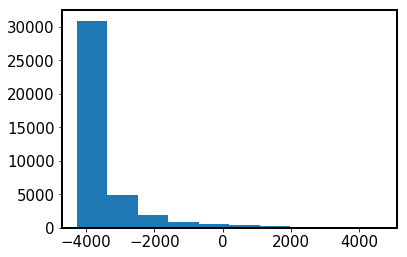

In [85]:
plt.hist(loglike.flatten())

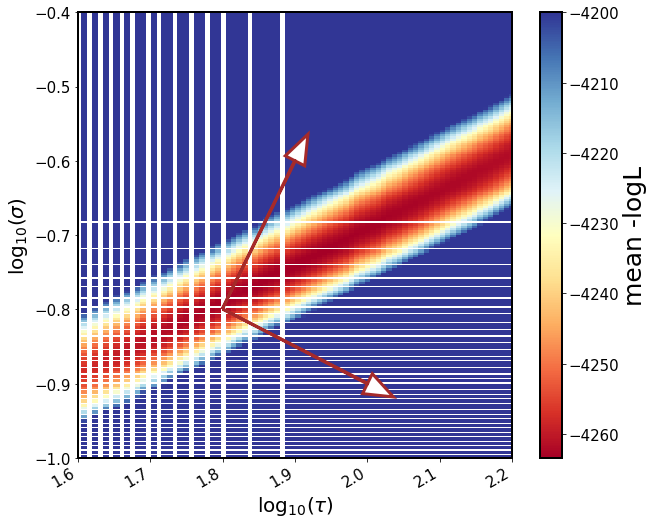

In [104]:
# Now, given that for each pixel I have a value of loglike,  tau,  sigma, sigma_hat, 
# I can also plot sigma_hat vs log(tau)  and color by loglike .. 
# plot 1 :  t1 vs t2 colored by  count 
from scipy.stats import binned_statistic_2d

x = np.log10(z_tau.flatten())
y = np.log10(z_sigma.flatten())
z = loglike.flatten()
nbins = 200
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)

z_vals, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_vals[np.isnan(z_vals)] =0
z_reduce  =  z_vals # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8.5,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=-4200)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label('mean -logL', fontsize=25)
ax.set_xlabel(r'$\log_{10}(\tau)$')
ax.set_ylabel(r'$\log_{10}(\sigma)$')


# Why this does not produce perpendicular arrows ? ? ? ? ?? ? ? ? ?? ?  
# After all,   a in the second line is exactly  -1/a of the first one...
a = 2 
x1 = 1.8
y1 = -0.8
b = y1 - a * x1

x2 = 1.9 ;  y2 = a * x2 + b  
dx = x2-x1
dy = y2-y1
ax.arrow( x1, y1, dx, dy, fc="white", ec="brown",
head_width=0.03, head_length=0.04 , lw=3)

a = -0.5
b = y1 - a * x1

x2 = 2.0 ; y2 = a * x2 + b
dx = x2-x1
dy = y2-y1
ax.arrow( x1, y1, dx, dy,  fc="white", ec="brown",
head_width=0.03, head_length=0.04 , lw=3)

x0 = 1.6
y0 = -1.0
dx = 0.6
dy = dx 
ax.set_xlim(x0, x0+dx)
ax.set_ylim(y0, y0+dy)
plt.savefig(outDir+'sim_lc_log-log_K_sigma_hat_arrows.png', bbox_inches='tight')

So in theory,  along the diagonal in log(sigma) = log(tau) space is sigma_hat,   and perpendicular to that : K . 



But the problem is that if the scales (yrange, xrange) are not identical, then what is supposedly perpendicular, stops appearing to be so. 


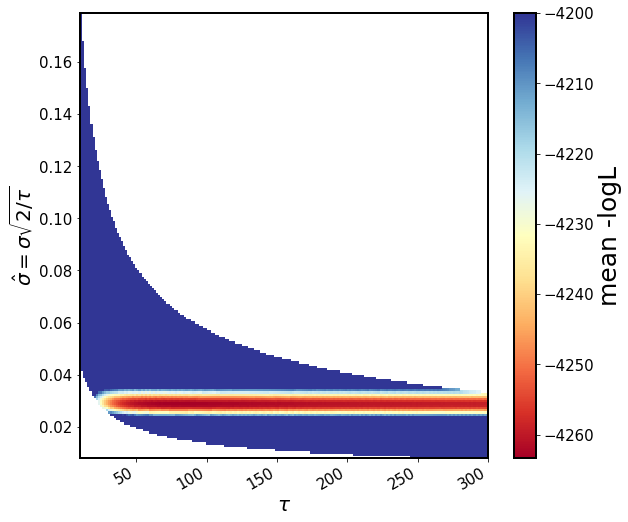

In [108]:
# Now, given that for each pixel I have a value of loglike,  tau,  sigma, sigma_hat, 
# I can also plot sigma_hat vs log(tau)  and color by loglike .. 
# plot 1 :  t1 vs t2 colored by  count 
from scipy.stats import binned_statistic_2d

x = z_tau.flatten()
y = z_sigma_hat.flatten()
z = loglike.flatten()
nbins = 200
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)

z_vals, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_vals[np.isnan(z_vals)] =0
z_reduce  =  z_vals # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=-4200)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label('mean -logL', fontsize=25)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\hat{\sigma} = \sigma \sqrt{2 / \tau}$')

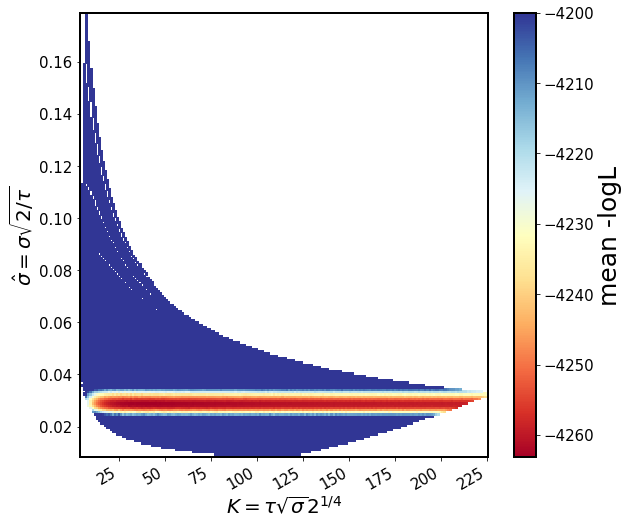

In [110]:
# Plot in space of sigma_hat  vs K  : 

# Now, given that for each pixel I have a value of loglike,  tau,  sigma, sigma_hat, 
# I can also plot sigma_hat vs log(tau)  and color by loglike .. 
# plot 1 :  t1 vs t2 colored by  count 
from scipy.stats import binned_statistic_2d

x = z_K.flatten()
y = z_sigma_hat.flatten()
z = loglike.flatten()
nbins = 200
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)

z_vals, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_vals[np.isnan(z_vals)] =0
z_reduce  =  z_vals # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=-4200)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label('mean -logL', fontsize=25)
ax.set_ylabel(r'$\hat{\sigma} = \sigma \sqrt{2 / \tau}$')
ax.set_xlabel(r'$K = \tau \sqrt{\sigma} 2^{1/4}$')

Now this doesn't make sense, because I would expect K to be very well constrained and sigma_hat very poorly, whereas it is the other way round here ... 

In [329]:
loglike

array([[-307.45711654, -322.68947841, -335.37899517, ...,  138.13419937,
         141.1105474 ,  144.08318288],
       [-308.74976309, -323.80473204, -336.37317102, ...,  119.97631851,
         122.88775481,  125.79565809],
       [-309.86236767, -324.74829228, -337.2016207 , ...,  102.48144101,
         105.32969254,  108.17458525],
       ..., 
       [ -81.75201012,  -91.84584407, -101.22450773, ..., -393.09589443,
        -393.33982478, -393.58068142],
       [ -80.71550307,  -90.80730019, -100.18487729, ..., -392.67889402,
        -392.92590132, -393.16983231],
       [ -79.6821688 ,  -89.77195448,  -99.14845969, ..., -392.25870843,
        -392.50876217, -392.75573702]])

In [300]:
bounds

[(None, None), (None, None)]

In [301]:
initial_params

array([-3.21887582, -4.60517019])

In [303]:
gp.get_parameter_names()

('kernel:log_a', 'kernel:log_c')

In [304]:
np.log(1/1)

0.0

In [305]:
np.log(1/1000)

-6.9077552789821368

In [309]:
2 * np.log(0.1)

-4.6051701859880909

In [310]:
bounds = [(-4.60517,  -2.40794  ), (- 6.9077, 0 )]

In [312]:
gp.get_parameter_bounds()

[(None, None), (None, None)]

In [313]:
gp.set_parameter?

In [322]:
gp.get_parameter_dict()

OrderedDict([('kernel:log_a', -1.83258146374831),
             ('kernel:log_c', -5.7037824746562009)])

In [324]:
gp.get_parameter_names()

('kernel:log_a', 'kernel:log_c')